<a href="https://colab.research.google.com/github/Techiefrankie/ml-basics/blob/master/make_up_recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **This notebook demonstrates using Convolutional Neural Network CNN model trained with pictures of different make-up styles for the appropriate faces to recommend make-up style most appropriate to new faces.**

# **Import Framework**

First, let's import the needed libraries

In [1]:
import tensorflow
from  tensorflow import keras
print('TensorFlow version:',tensorflow.__version__)
print('Keras version:',keras.__version__)
print('Done importing libraries...')

TensorFlow version: 2.3.0
Keras version: 2.4.0
Done importing libraries...


# **Link Google Drive** 
Configure colab to load datasets from Google drive

In [18]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [19]:
!ls '/content/gdrive/My Drive/project/dataset/'

after  before


In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_folder = '/content/gdrive/My Drive/project/dataset/'
img_size = (128, 128)
batch_size = 20

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.2) # hold back 20% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    data_folder,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

classnames = list(train_generator.class_indices.keys())
print("class names: ", classnames)

Getting Data...
Preparing training dataset...
Found 239 images belonging to 2 classes.
Preparing validation dataset...
Found 58 images belonging to 2 classes.
class names:  ['after', 'before']


In [21]:
# Define a CNN classifier network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Define the model as a sequence of layers
model = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
model.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we;ll add a max pooling layer with a 2x2 patch
model.add(MaxPooling2D(pool_size=(2,2)))

# We can add as many layers as we think necessary - here we'll add another convolution, max pooling, and dropout layer
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# And another set
model.add(Conv2D(32, (6, 6), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# A dropout layer randomly drops some nodes to reduce inter-dependencies (which can cause over-fitting)
model.add(Dropout(0.2))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
model.add(Flatten())
model.add(Dense(train_generator.num_classes, activation='sigmoid'))

# With the layers defined, we can now compile the model for categorical (multi-class) classification
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 123, 123, 32)      3488      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 61, 61, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 32)        36896     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 23, 23, 32)        36896     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 11, 11, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 11, 11, 32)       

In [22]:
# Train the model over 5 epochs using 20-image batches and using the validation holdout dataset for validation
num_epochs = 5
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

Epoch 1/5
11/11 [==============================] - 11s 1s/step - loss: 0.7444 - accuracy: 0.4955 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 2/5
11/11 [==============================] - 11s 1s/step - loss: 0.6930 - accuracy: 0.5068 - val_loss: 0.6935 - val_accuracy: 0.4750
Epoch 3/5
11/11 [==============================] - 11s 980ms/step - loss: 0.6924 - accuracy: 0.5068 - val_loss: 0.6947 - val_accuracy: 0.4500
Epoch 4/5
11/11 [==============================] - 11s 1000ms/step - loss: 0.6903 - accuracy: 0.5479 - val_loss: 0.6905 - val_accuracy: 0.5000
Epoch 5/5
11/11 [==============================] - 11s 998ms/step - loss: 0.6915 - accuracy: 0.5388 - val_loss: 0.6851 - val_accuracy: 0.6250


# **View the Loss History**

We tracked average training and validation loss history for each epoch. We can plot these to verify that loss reduced as the model was trained, and to detect overfitting (which is indicated by a continued drop in training loss after validation loss has levelled out or started to increase.

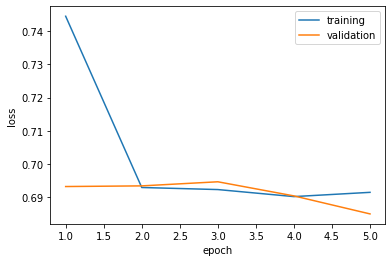

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

epoch_nums = range(1,num_epochs+1)
training_loss = history.history["loss"]
validation_loss = history.history["val_loss"]
plt.plot(epoch_nums, training_loss)
plt.plot(epoch_nums, validation_loss)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

Generating predictions from validation data...


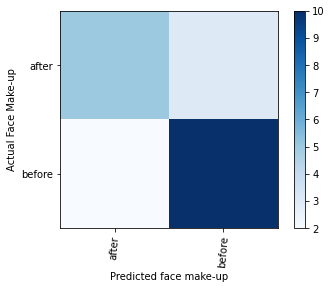

In [26]:
# Tensorflow doesn't have a built-in confusion matrix metric, so we'll use SciKit-Learn
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

print("Generating predictions from validation data...")
# Get the image and label arrays for the first batch of validation data
x_test = validation_generator[0][0]
y_test = validation_generator[0][1]

# Use the moedl to predict the class
class_probabilities = model.predict(x_test)

# The model returns a probability value for each class
# The one with the highest probability is the predicted class
predictions = np.argmax(class_probabilities, axis=1)

# The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
true_labels = np.argmax(y_test, axis=1)

# Plot the confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(classnames))
plt.xticks(tick_marks, classnames, rotation=85)
plt.yticks(tick_marks, classnames)
plt.xlabel("Predicted face make-up")
plt.ylabel("Actual Face Make-up")
plt.show()

# **Predicting with the Trained Model**

before


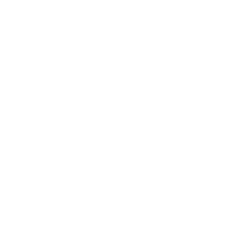

In [14]:
from tensorflow.keras import models
from random import randint
import os
%matplotlib inline

# Function to create a random image (of a square, circle, or triangle)
def create_image (size, shape):
    from random import randint
    import numpy as np
    from PIL import Image, ImageDraw
    
    xy1 = randint(10,40)
    xy2 = randint(60,100)
    col = (randint(0,200), randint(0,200), randint(0,200))

    img = Image.new("RGB", size, (255, 255, 255))
    draw = ImageDraw.Draw(img)
    
    if shape == 'before':
        draw.ellipse([(xy1,xy1), (xy2,xy2)], fill=col)
    elif shape == 'after':
        draw.polygon([(xy1,xy1), (xy2,xy2), (xy2,xy1)], fill=col)
    
    return np.array(img)

# Save the trained model
modelFileName = '/content/gdrive/My Drive/project/model/recommender_classifier.h5'
model.save(modelFileName)
del model  # deletes the existing model variable

# Create a random test image
classnames = os.listdir(os.path.join('/content/gdrive/My Drive/project', 'dataset'))
classnames.sort()
img = create_image ((128,128), classnames[randint(0, len(classnames)-1)])
plt.axis('off')
plt.imshow(img)

# The model expects a batch of images as input, so we'll create an array of 1 image
imgfeatures = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])

# We need to format the input to match the training data
# The generator loaded the values as floating point numbers
# and normalized the pixel values, so...
imgfeatures = imgfeatures.astype('float32')
imgfeatures /= 255

# Use the classifier to predict the class
model = models.load_model(modelFileName) # loads the saved model
class_probabilities = model.predict(imgfeatures)
# Find the class predictions with the highest predicted probability
class_idx = np.argmax(class_probabilities, axis=1)
print (classnames[int(class_idx[0])])